In [ ]:
import torch
from torch import nn
from torch import optim

import numpy as np
from numpy import random
import re
import time

!pip install conllu
import conllu

In [ ]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

# Model Implementation

За основу взята модель из статьи [UNIVERSAL LEMMATIZER: A SEQUENCE TO SEQUENCE MODEL FOR LEMMATIZING UNIVERSAL DEPENDENCIES TREEBANKS](https://arxiv.org/pdf/1902.00972.pdf).

In [ ]:
class Masking(nn.Module):
  def __init__(self, list_of_characters, max_len=20):
    self.chars = list(list_of_characters)
    self.size_vocab = len(self.chars) + 1
    self.max_len = max_len
  
  def split_elem(self, input_string):
    return [i for i in input_string]
  
  def mask_elem(self, input_string):
    chars = self.split_elem(input_string)
    chars = chars[:self.max_len]
    res = np.zeros(self.max_len) + len(self.chars)
    for ind, char in enumerate(chars):
      try:
        ind_char = self.chars.index(char)
      except:
        ind_char = len(self.chars)
      res[ind] = ind_char
    return res
  
  def mask_batch(self, strings):
    res = []
    for input_string in strings:
      res += [self.mask_elem(input_string)]
    res = np.array(res)
    res = torch.tensor(res).to(torch.int64)
    return res
  
  def unmask_elem(self, ind_list):
    out = ""
    for ind in ind_list:
      if ind < len(self.chars):
        out += self.chars[int(ind)]
    return out

  def unmask_batch(self, input_lists):
    res = []
    for ind_list in input_lists:
      res += [self.unmask_elem(ind_list)]
    return res

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers,
                 dropout=0.2,
                 bidirectional=True):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim,
                           hid_dim,
                           n_layers,
                           dropout=dropout,
                           bidirectional=bidirectional)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        output, (hidden, cell) = self.rnn(embedded)
        return output, (hidden, cell)
    
    
class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers,
                 dropout,
                 attention, device):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim + 2 * self.enc_hid_dim,
                           dec_hid_dim,
                           n_layers ,
                           dropout=dropout,
                           bidirectional=False)
        
        self.out = nn.Linear(dec_hid_dim, output_dim)
        self.device = device
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, prev_out):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))

        if prev_out is None:
          prev_out = torch.zeros(size=(1, input.shape[1], 2 * self.enc_hid_dim))
        prev_out = prev_out.to(self.device)
        emb = torch.cat([prev_out, embedded], dim=-1)
        output, hidden = self.rnn(emb, hidden)
        
        attn = self.attention(output, encoder_outputs)
        prev_out = attn
        attn_emb = torch.cat([attn, output], dim=-1)
        prediction = self.out(output.squeeze(0))
        return prediction, hidden, prev_out

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.start = None

        
    def forward(self, src, trg=None, teacher_forcing_ratio = 0):
        src = src.permute(1, 0)
        if trg is not None:
          trg = trg.permute(1, 0)
        batch_size = src.shape[1]
        max_len = src.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        enc_states, hidden = self.encoder(src)
        
        if trg is not None:
          input = trg[0,:]
          self.start = input
        else:
          input = torch.zeros(batch_size).to(torch.int64).to(self.device)
        prev_out = None
        
        for t in range(1, max_len):
            output, hidden, prev_out = self.decoder(input, hidden, enc_states, prev_out)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        return outputs

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim, dim, attention_type='general'):
        super(Attention, self).__init__()

        if attention_type not in ['dot', 'general']:
            raise ValueError('Invalid attention type selected.')

        self.attention_type = attention_type
        if self.attention_type == 'general':
            self.linear_in = nn.Linear(dim, 1, bias=False)

        self.linear_out = nn.Linear(2 * enc_dim + dec_dim, dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, query, context):
        batch_size, output_len, dimensions = query.size()
        query_len = context.size(1)

        scores = None
        for i in range(len(context)):
          z = torch.cat([query[0], context[i]], dim=-1)
          z = self.linear_out(z)
          score_new = self.linear_in(self.tanh(z))
          if scores is None:
            scores = score_new
          else:
            scores = torch.cat([scores, score_new], dim=-1)
        a_t = self.softmax(scores)
        output = None
        for i in range(len(context)):
          cur = context[i] * a_t[:, i].view(-1, 1)
          if output is None:
            output = cur
          else:
            output += cur
        return output.view(1, output.shape[0], output.shape[1])

In [ ]:
def train(model, train_src, train_trg, batch_size, optimizer, criterion, clip, device, train_history=None, valid_history=None):
    model.train()
    model.to(device)
    
    epoch_loss = 0
    history = []
    indexes = [i for i in range(len(train_src))]
    indexes = np.random.permutation(indexes)
    indexes = np.array_split(indexes, len(indexes) // batch_size)
    for i, idx in enumerate(indexes):
        src = train_src[idx].to(device)
        trg = train_trg[idx].to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg).to(device)
        output = output.view(-1, output.shape[-1])
        trg = trg.view(-1)
        
        loss = criterion(output, trg)
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()        
    return epoch_loss / len(indexes)
  
def evaluate(model, val_src, val_trg, batch_size, device, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
            indexes = [i for i in range(len(val_trg))]
            indexes = np.random.permutation(indexes)
            indexes = np.array_split(indexes, len(indexes) // batch_size)
            for idx in indexes:
                src = val_src[idx].to(device)
                trg = val_trg[idx].to(device)
                output = model(src, None, 0)
                output = output[1:].view(-1, output.shape[-1])
                trg = trg[:, 1:].contiguous()
                trg = trg.view(-1)
                loss = criterion(output, trg)
                epoch_loss += loss.item()
    return epoch_loss / len(indexes)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Dataset Preprocessing

In [ ]:
with open("ru_syntagrus-ud-dev.conllu", 'r') as f:
    data = f.read()
train_sentences = conllu.parse(data)
len(train_sentences)

6584

In [ ]:
START_TOKEN = "<"
END_TOKEN = ">"
rus_re = re.compile(r'[а-яА-ЯёЁ]+')
def extract_sequence(target, sentence, morph=False, use_context=True):
  out = []
  for ind, token in enumerate(sentence):
    if rus_re.fullmatch(token['form']):
      if ind == target:
        out += [START_TOKEN]
        out += [i for i in token["form"].lower()]
        out += [END_TOKEN]
      elif use_context:
        out += [i for i in token["form"].lower()]
      if ind < len(sentence) and use_context:
        out += [" "]
  if morph:
    out += ["."]
    if "feats" in sentence[target] and sentence[target]["feats"] is not None:
      for key in sentence[target]["feats"]:
        out += [key+"="+sentence[target]["feats"][key]]
    if "upos" in sentence[target] and sentence[target]["upos"] is not None:
      out += ["upos" + sentence[target]["upos"]]
  return out

def get_dataset(sentences, use_context=True, morph=False):
  src = []
  trg = []
  for sentence in sentences:
    for ind, token in enumerate(sentence):
      if rus_re.fullmatch(token['form']) and token['lemma'] is not None:
        src.append(extract_sequence(ind, sentence, morph=morph, use_context=use_context))
        trg.append([i for i in token['lemma'].lower()])
  return src, trg

Будем учить лемму на основе словоформы.

In [ ]:
src, trg = get_dataset(train_sentences[:20000], use_context=True, morph=False)
src1, trg1 = [], []
for ind, i in enumerate(src):
  if len(i) <= 80:
    src1.append(i)
    trg1.append(trg[ind])
src, trg = src1, trg1

In [ ]:
list_of_chars = ["<s>"] + list(np.unique(list(set().union(*(src + trg))) ))
trg = [["<s>"] + i for i in trg]

In [ ]:
mask = Masking(list_of_chars, max_len=80)
train_src = mask.mask_batch(src)
train_trg = mask.mask_batch(trg)
train_src.shape, mask.size_vocab

(torch.Size([21385, 80]), 39)

In [20]:
input_dim = mask.size_vocab
emb_dim = 100
enc_hid_dim = 100
n_layers = 2
output_dim = mask.size_vocab
dec_hid_dim = enc_hid_dim

device = torch.device("cuda:0")
attention = Attention(enc_hid_dim, dec_hid_dim, 100)
encoder = Encoder(input_dim, emb_dim, hid_dim=enc_hid_dim, n_layers=n_layers,
                 dropout=0.1,
                 bidirectional=True)
decoder = DecoderWithAttention(output_dim, emb_dim, enc_hid_dim=enc_hid_dim,
                               n_layers=n_layers * 2,
                               dec_hid_dim=dec_hid_dim,
                               dropout=0.1,
                               attention=attention, device=device)
lemmatizer = Seq2Seq(encoder, decoder, device).to(device)

In [21]:
criterion = nn.CrossEntropyLoss()

BATCH_SIZE = 128
optimizer = optim.Adam(lemmatizer.parameters(), lr=1e-3)

Выберем последние 2000 сэмплов за тест, а 3000 сэмплов перед этим на валидацию.

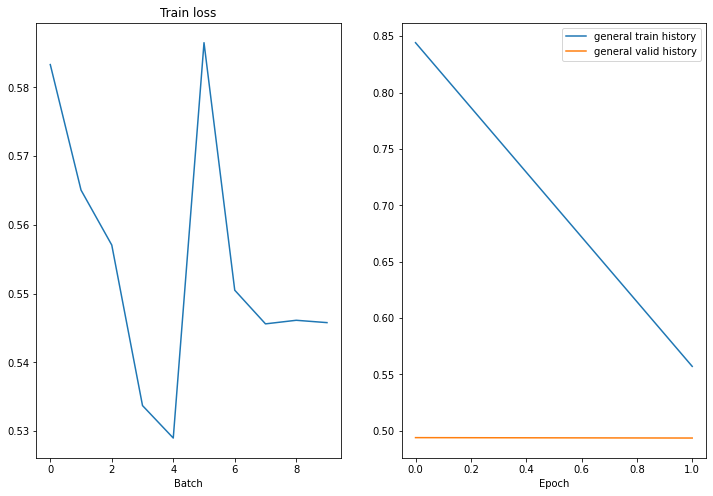

In [ ]:
%matplotlib inline
train_history = []
valid_history = []

N_EPOCHS = 3
CLIP = 1

best_valid_loss = float('inf')
valid_loss = 0
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(lemmatizer, train_src[:-5000], train_trg[:-5000], BATCH_SIZE, optimizer, criterion, CLIP, device, train_history, valid_history)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    valid_loss = evaluate(lemmatizer, train_src[-5000:-2000], train_trg[-5000:-2000], BATCH_SIZE, device, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(lemmatizer.state_dict(), 'model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')